In [12]:
import numpy as np
from matplotlib import pyplot as plt
from numpy.polynomial.legendre import legval
from scipy.linalg import det, eigh
import time

## Exercise 17

Find Gaussian integration rules of arbitrary order. Use that the monic Legendre polynomials are 
  $$
  \tilde L_n(x) = \det ( x I - A_n)
  $$
  with
  $$
  A_n = \left( \begin{array}{ccccc}  0 & \gamma_1 & 0 & \ldots&  0 \\
                 \gamma_1 & 0 & \gamma_2 & \ddots & \vdots \\
                 0 & \gamma_2 & \ddots & \ddots  & 0 \\
                 \vdots & & \ddots & \ddots & \gamma_{n-1} \\
                 0 & \cdots & 0 & \gamma_{n-1} & 0 
                 \end{array} \right)
  $$
  and
  $$
  \gamma_j = \frac{1}{\sqrt{ 4-j^{-2}}}. 
  $$
  Verify the formulas by plotting Legendre polynomials $L_n(x)$, and
  $\tilde L_n(x) / \tilde L_n(1)$.

  Find roots of $\tilde L_n$ by computing the eigenvalues of $A_n$.

  Find integration weights by solving a linear system of
  equations. The integration rule with $n+1$ points must be exact (at
  least) for polynomials up to
  order $n$. To set up the equation, use either monomials $x^i$, or
  Legendre polynomials. Test your integration rules as in Ex 15. How
  far can you go with $n$ ? 

  You may use libraries for finding eigenvalues (scipy.linalg.eigh), solving linear
  systems, computing determinants, and evaluating Legendre polynomials.

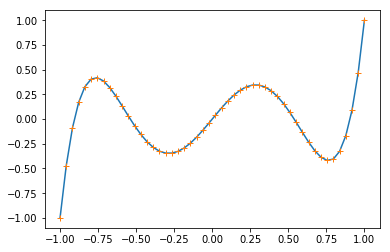

In [13]:
def A(n):
    gamma = [1/np.sqrt(4-1/j**2) for j in range(1,n)]
    return np.diag(gamma, -1) + np.diag(gamma, 1)

def L(n, x):
    coef = np.zeros(n+1)
    coef[-1] = 1
    return legval(x,coef)
    
def Ltilde(n,x):
    mat = x*np.eye(n) - A(n)
    return det(mat)

n = 5
x = np.linspace(-1,1)
y1 = [L(n, xi) for xi in x]
y2 = [Ltilde(n, xi)/Ltilde(n,1) for xi in x]
plt.plot(x,y1)
plt.plot(x,y2, '+')
plt.show()

In [14]:
def Roots(n):
    return eigh(A(n), eigvals_only = True)

The linear system of equation reads as
$$
    \sum_{j=0}^n \omega_j x_j^k = \int_{-1}^1 x^k\, dx
$$
for all $k = 0,\dots, n$. The right-hand side evaluates to
$$
    b_k := \int_{-1}^1 x^k\, dx = \begin{cases} 
        \frac{2}{k+1}, &\text{if } k \text{ is even} \\
        0, &\text{else}.
    \end{cases}
$$
The coefficients can thus be computed by means of the Vandermonde matrix of the nodes $x_0,\dots, x_n$, i.e.,
$$
    A\omega = b,
$$
where $\omega = (\omega_0,\dots,\omega_n)^T$ is the collection of weights, $b = (b_0,\dots,b_n)^T$, and
$A_{i,k} = x_j^i$ for all $i,j = 0,\dots,n$.

In [15]:
def Weights(n):
    b = np.zeros(n)
    for i in range(0, n, 2):
        b[i] = 2/(i+1)
    A = np.transpose(np.vander(Roots(n), n, increasing = True))
    return np.linalg.inv(A) @ b

def GaussQuad(n):
    w = [0.5* wi for wi in Weights(n)]
    T = lambda x: 0.5*(1+x)
    nodes = T(Roots(n))
    return nodes, w

In [16]:
def CompQuad(f, a, b, m, nodes, weights):
    assert(len(weights) == len(nodes))
    x = np.linspace(a,b,m+1)
    h = x[1]-x[0]
    quad = 0
    for i in range(m):
        for k in range(len(weights)):
            quad += weights[k] * f(x[i] + nodes[k] * h)
    return h*quad

f1 = lambda x: np.exp(x)
f2 = lambda x: np.sqrt(x)
n = 30
num = [i for i in range(1,n)]

int1 = np.exp(1)-1
int2 = 2/3

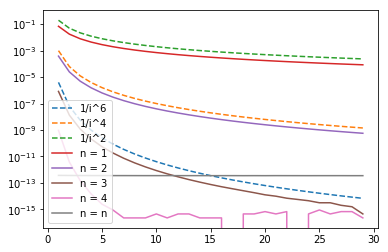

In [17]:
a = 0
b = 1
y1 = []
y2 = []
y3 = []
y4 = []
yn = []
yquad = []
yfour = []
ysix = []

n = 15
for i in range(1,len(num)+1):
    
    ysix.append(4e-6/i**6)
    yfour.append(1e-3/i**4)
    yquad.append(2e-1/i**2)
    
    error = abs(int1 - CompQuad(f1, a, b, i, *GaussQuad(1)))
    y1.append(error)
                
    error = abs(int1 - CompQuad(f1, a, b, i, *GaussQuad(2)))
    y2.append(error)
                
    error = abs(int1 - CompQuad(f1, a, b, i, *GaussQuad(3)))
    y3.append(error)
                
    error = abs(int1 - CompQuad(f1, a, b, i, *GaussQuad(4)))
    y4.append(error)
    
    error = abs(int1 - CompQuad(f1, a, b, i, *GaussQuad(n)))
    yn.append(error)

plt.plot(num, ysix, '--',label = '1/i^6')
plt.plot(num, yfour, '--',label = '1/i^4')
plt.plot(num, yquad, '--', label = '1/i^2')
plt.plot(num, y1, label = 'n = 1')
plt.plot(num, y2, label = 'n = 2')
plt.plot(num, y3, label = 'n = 3')
plt.plot(num, y4, label = 'n = 4')
plt.plot(num, yn, label = 'n = n')
plt.yscale('log')
plt.legend()
plt.show()


As the monomials $x^j$, $j = 0,\dots,k$ are numerically close to linearly dependent, the arising system matrix is ill-conditioned, as shown in the following example.

In [18]:
n = 15
mat = np.transpose(np.vander(Roots(n), n, increasing = True))
print('cond(mat) = ', np.linalg.cond(mat))

cond(mat) =  140157.24477840576


In this respect, the weights should preferably be computed by means of the Legendre polynomials, as the exhibit superior numerical stability compared to the monomial basis. 

## Exercise 18

Find quadrature rules for the circle. Let $K = \{ (x,y) : x^2 + y^2 \leq 1 \}$. Find integration points
  $(x_i, y_i) $ and integration weights $\omega_i$ such that
  $$
  \int_K f(x,y) d(x,y) \approx \sum_{i = 0}^{n-1} \omega_i f(x_i,
  y_i) 
  $$
Hint: Use polar coordinates $x = r \cos \varphi, y = r \sin
\varphi$ to  transform the integral to a rectangular integration domain:
$$
\int_K f (x,y) d(x,y) = \int_0^1 \int_0^{2 \pi} r f(r \cos \varphi,
r \sin \varphi) \, d \varphi \, dr
$$
Compare different rules for the $r$-integral and $\varphi$-integral.

Test for functions $f(x,y) = 1$, $f(x,y) = x^3 y^4$, $f(x,y) = \exp (
-(x-1)^2 - y^2)$.

Consider the two 1D quadratures
$$
    \sum_{j=0}^n \omega_jf(x_j) \approx \int_0^{2\pi}f(x)\, dx, \quad \sum_{i=0}^m \theta_if(y_i) \approx \int_0^1f(x)\, dx.
$$
Then
\begin{align*}
    \int_K f (x,y) d(x,y) &= \int_0^1 \int_0^{2 \pi} r f(r \cos \varphi,
r \sin \varphi) \, d \varphi \, dr \\
&\approx \int_0^1 r \sum_{j = 0}^n \omega_j f(r \cos x_j,
r \sin x_j) \, dr \approx  \sum_{i = 0}^m \sum_{j = 0}^n \theta_i\omega_j y_if(y_i \cos x_j, y_i \sin x_j) \, dr
\end{align*}

In [19]:
def CompQuad(f, a, b, m, nodes, weights):
    assert(len(weights) == len(nodes))
    x = np.linspace(a,b,m+1)
    h = x[1]-x[0]
    quad = 0
    for i in range(m):
        for k in range(len(weights)):
            quad += weights[k] * f(x[i] + nodes[k] * h)
    return h*quad

def CompTrapQuad(m):
    nodes = np.linspace(0, 2*np.pi, m+1)
    h = nodes[1]-nodes[0]
    weights = [0.5]
    weights.extend(np.ones(m-1))
    weights.append(0.5)
    #transform wéights
    weightssclaled = [h * w for w in weights]
    return nodes, weightssclaled

def TwoDGaussQuad(n,m):
    #Gaussian Quadrature
    #nphi, wphi = GaussQuad(n)
    #Transformation [0,1] -> [0,2pi]
    #nodesphi = [2*np.pi * node for node in nphi]
    #weightsphi = [2*np.pi * w for w in wphi]
    
    #Trapezoidal rule
    nodesphi, weightsphi = CompTrapQuad(n)  
    #print(nodesphi, weightsphi)
    nodesr, weightsr = GaussQuad(m)
    weights = []
    nodes = []
    for j in range(len(nodesphi)):
        for i in range(len(nodesr)):
            weights.append(nodesr[i] * weightsphi[j] * weightsr[i])
            nodes.append([nodesr[i]*np.cos(nodesphi[j]),nodesr[i]*np.sin(nodesphi[j])])
    return nodes, weights
    
def Comp2DQuad(f, nodes, weights):
    y = [f(*node) for node in nodes]
    return sum(np.multiply(y, weights))
    
    
nodes, weights = TwoDGaussQuad(1,1)
f1 = lambda x,y: 1
int1 = np.pi
print('error = ', abs(int1 - Comp2DQuad(f1, nodes, weights)))

nodes, weights = TwoDGaussQuad(10,3)
f2 = lambda x,y: x**3 * y**4
int2 = 0
print('error = ', abs(int2 - Comp2DQuad(f2, nodes, weights)))

nodes, weights = TwoDGaussQuad(10,5)
f3 = lambda x,y: np.exp(-(x-1)**2 - y**2)
int3 = 1.086192512
print('error = ', abs(int3 - Comp2DQuad(f3, nodes, weights)))

error =  0.0
error =  1.734723475976807e-18
error =  9.444413251458172e-08


## Exercise 19

>Calculate the LU decomposition of the matrix
>
>  $$
  A = \left( \begin{array}{cc}
               10^{-6} & 1 \\
               1 & 0
                   \end{array} \right)
  $$
>
>by hand.   Find a normalized lower left triangular matrix $L$ and an upper right
  triangular matrix $U$ such that
> $$
  A = L U.
  $$
> 
>Furthermore, calculate $A^{-1}$, $L^{-1}$, and $U^{-1}$, and the
 condition numbers
>
>$$
\operatorname{cond}_{\infty} (M) = \| M \|_\infty \| M^{-1} \|_{\infty}
$$
  >
  >for all of these matrices. The maximum absolute row sum norm
  (Zeilenbetragssummennorm) is defined as
> $$
  \| M \|_{\infty} = \max_{i = 1, \ldots n} \sum_{j =1}^n | M_{i,j} |.
  $$
>
>Then, swap the rows of $A$ and repeat the calculations.


$$
\newcommand{\setB}{{\mathbb B}}
\newcommand{\setR}{{\mathbb R}}
\newcommand{\setN}{{\mathbb N}}
\newcommand{\setZ}{{\mathbb Z}}
\newcommand{\setQ}{{\mathbb Q}}
\newcommand{\setC}{{\mathbb C}}
$$

The $LU$ decomposition of $A$ with normalized $L$ is given as

$$
  A = LU = \left( \begin{array}{cc}
               1 & 0 \\
               10^{6} & 1
                   \end{array} \right)
            \left( \begin{array}{cc}
               10^{-6} & 1 \\
               0 & -10^{6}
                   \end{array} \right).
  $$

To calculate the Inverse of $A$ we can use $A^{-1} = (LU)^{-1} = U^{-1}L^{-1}$ and get

$$
\begin{split}
L^{-1} &= \left( \begin{array}{cc}
               1 & 0 \\
               -10^{6} & 1
                   \end{array} \right) \\
U^{-1} &= \left( \begin{array}{cc}
               10^6 & 1 \\
               0 & -10^{-6}
                   \end{array} \right) \\
A^{-1} &= \left( \begin{array}{cc}
               0 & 1 \\
               1 & -10^{-6}
                   \end{array} \right)
\end{split}
$$

For the condition numbers we get

$$
\begin{split}
\operatorname{cond}_{\infty} (A) &= (1+10^{-6})^2 \\
\operatorname{cond}_{\infty} (L) &= (1+10^{6})^2 \\
\operatorname{cond}_{\infty} (U) &= (1+10^{-6})(1+10^{6})
\end{split}
$$


If we swap the lines and set

$$
  A := \left( \begin{array}{cc}
              1 & 0 \\
               10^{-6} & 1
              \end{array} \right)
$$

we see that the new $A$ is already a lower triangle matrix and therefore 

$$
  A = LU = \left( \begin{array}{cc}
              1 & 0 \\
               10^{-6} & 1
              \end{array} \right)
            \left( \begin{array}{cc}
               1 & 0 \\
               0 & 1
                   \end{array} \right).
$$

The inverses are also easy to calculate as

$$
\begin{split}
L^{-1} &= \left( \begin{array}{cc}
               1 & 0 \\
               -10^{-6} & 1
                   \end{array} \right) \\
U^{-1} &= \left( \begin{array}{cc}
               1 & 0 \\
               0 & 1
                   \end{array} \right) \\
A^{-1} &= \left( \begin{array}{cc}
               1 & 0 \\
               -10^{-6} & 1
                   \end{array} \right)
\end{split}
$$

and for the condition numbers we get

$$
\begin{split}
\operatorname{cond}_{\infty} (A) &= (1+10^{-6})^2 \\
\operatorname{cond}_{\infty} (L) &= (1+10^{-6})^2 \\
\operatorname{cond}_{\infty} (U) &= 1
\end{split}
$$

## Exercise 20

Measure timings for

* (a) inner products of vectos $x \cdot y$
* (b) matrix vector products $y = A x $
* (c) matrix matrix products $A = B C$

  where $x$ and $y$ are vectors in $\setR^n$, and $A,B,C$ are $n
  \times n $ matrices. Plot the number of floating point operations
  per second you have measured.


  Compare different programming languages and libraries:

  * loops written in Python
  * numpy matrices
  * hand-written C++ loops
  * C++ library Eigen: http://eigen.tuxfamily.org
  * C++ library Blaze:
    https://bitbucket.org/blaze-lib/blaze/src/master/
    \item C++ library ngbla: https://github.com/NGSolve/ngbla

  Choose at least three of the list.
  Repeat the operations for small matrices and vectors to obtain
  accurate results. Go up to matrix / vectors sizes such that the
  time is in the range of seconds (if you have enough memory).

In [20]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

nvec = [20*2**j for j in range(7)]
pydata = np.empty((6,7)) 
pydata.fill(None)

togiga = 1e-9;
runvar = 1e5
cnt = 0
for n in nvec:
    
    print('Gigaflops for ', n)
    a = np.random.random_sample((n, n))
    b = np.random.random_sample((n, n))
    c = np.random.random_sample((n, n))
    x = np.random.random_sample((n, ))
    y = np.random.random_sample((n, ))
    
    # np scalar product
    runs = int(runvar/n)+1
    start = time.time()
    for _ in range(runs):
        x.dot(y)
    end = time.time()
    flops = n*runs/(end-start)*togiga
    pydata[0,cnt] = flops
    print("np inner prod ", flops)
    
    # manual scalar product
    runs = int(runvar/n)+1
    start = time.time()
    for _ in range(runs):
        sum = 0;
        for j in range(n):
            sum += x[j]*y[j];
    end = time.time()
    flops = n*runs/(end-start)*togiga
    pydata[1,cnt] = flops
    print("manual inner prod ", flops)
    
    # np matrix vector product
    runs = int(runvar/n/n)+1
    start = time.time()
    for _ in range(runs):
        y = a@x
    end = time.time()
    flops = n*n*runs/(end-start)*togiga
    pydata[2,cnt] = flops
    print("numpy matrix vector prod ", flops)

    # manual matrix vector product
    runs = int(runvar/n/n)+1
    start = time.time()
    for _ in range(runs):
        sum = 0;
        for j in range(n):
            y[j] = 0;
            for k in range(n):
                y[j] += a[j,k]*x[k]
                
    end = time.time()
    flops = n*n*runs/(end-start)*togiga
    pydata[3,cnt] = flops
    print("manual matrix vector prod ", flops)
    
    
    # np matrix vector product
    runs = int(runvar/n/n/n)+1
    start = time.time()
    for _ in range(runs):
        c = a@b
    end = time.time()
    flops = n*n*n*runs/(end-start)*togiga
    pydata[4,cnt] = flops
    print("numpy matrix matrix prod ", flops)
    
    if cnt < 5:
        # manual matrix vector product
        runs = int(runvar/n/n/n)+1
        start = time.time()
        for _ in range(runs):
            for i in range(n):
                    for j in range(n):
                        sum = 0;
                        for k in range(n):
                            sum += a[i,k]*b[k,j];
                            c[i,j] = sum;

        end = time.time()
        flops = n*n*n*runs/(end-start)*togiga
        pydata[5,cnt] = flops
        print("manual matrix matrix prod ", flops)

    cnt+=1

Gigaflops for  20
0   20
np inner prod  0.02590233922449988
manual inner prod  0.0016983902726643374
numpy matrix vector prod  0.3229356760736196
manual matrix vector prod  0.0015275749774187348
numpy matrix matrix prod  1.4255150849673204
manual matrix matrix prod  0.0013293743821046536
Gigaflops for  40
1   40
np inner prod  0.05799560085141672
manual inner prod  0.0017593067234656313
numpy matrix vector prod  0.9522203675675677
manual matrix vector prod  0.0015135603625792964
numpy matrix matrix prod  0.49209066177818517
manual matrix matrix prod  0.0014638207874359255
Gigaflops for  80
2   80
np inner prod  0.1124172320085699
manual inner prod  0.0020245197250905516
numpy matrix vector prod  1.8592932017316017
manual matrix vector prod  0.0015905224493121264
numpy matrix matrix prod  2.1262214336633662
manual matrix matrix prod  0.0014384182489946067
Gigaflops for  160
3   160
np inner prod  0.17703391851664563
manual inner prod  0.0020186220401416538
numpy matrix vector prod  1.55

640


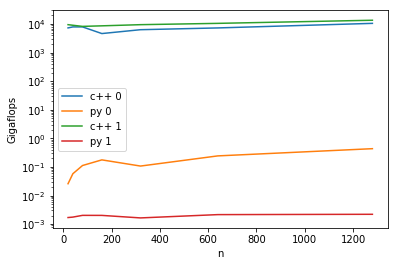

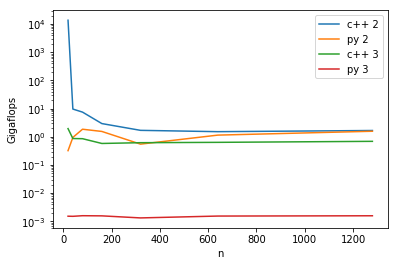

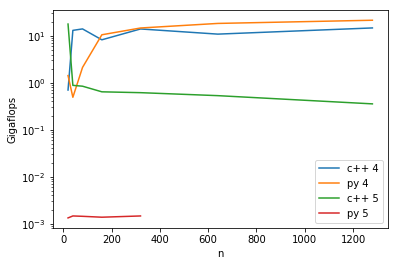

In [21]:
cdata = np.loadtxt('data.txt')

x = 20*2**np.arange(len(pydata[0,:]))
plt.figure()

pylabels = ["numpy", "manual"]
cpplabels = ["ngbla", "manual"]
titles = ["scalar prod", "matrix vector prod", "matrix matrix prod"]
for j in [0,2,4]:
    plt.figure()
    
    for i in range(2):
        plt.plot(x[1:],cdata[i+j,1:], label="c++ "+cpplabels[i])
        plt.plot(x[1:],pydata[i+j,1:], label="py "+pylabels[i])
    plt.title(titles[int(j/2)])
    plt.yscale('log')
    plt.xlabel('n')
    plt.ylabel('Gigaflops')
    plt.legend()